In [1]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
data = pd.read_excel('./data/tb_stock.xlsx')
df = data[['sc_date', 'sc_coin']]

# 전체 데이터 중 80%를 훈련데이터로, 20%를 테스트 데이터로 나누기
df.set_index('sc_date', inplace=True)
train_size = int(len(df) * 0.8)
train = df['sc_coin'][:train_size]
test = df['sc_coin'][train_size:]

In [ ]:
# Exponential Smoothing 모델 초기화
model = ExponentialSmoothing(
    train,
    trend='add',
    seasonal='add',
    seasonal_periods=12
).fit()

In [4]:
# 파라미터 옵션 설정
param_grid = {
    'trend': [None, 'add', 'mul'],  # 트렌드(추세) 옵션: 없음, 덧셈적, 곱셈적. 
    'seasonal': [None, 'add', 'mul'],  # 계절성 옵션: 없음, 덧셈적, 곱셈적
    'seasonal_periods': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],  # 계절성 주기: None ~ 12
    'damped_trend': [True, False],  # 댐핑된 트렌드 사용 여부
}

In [ ]:
# 최적 하이퍼파라미터 초기화
best_score = float('inf')
best_params = None
best_model = None

# 그리드 서치 수행
for params in ParameterGrid(param_grid):  # ParameterGrid를 통한 파라미터 조합 생성
    try:
        # 모델 생성 및 학습
        model = ExponentialSmoothing(
            train,
            trend=params['trend'],
            seasonal=params['seasonal'],
            seasonal_periods=params['seasonal_periods'],
            damped_trend=params['damped_trend']
        ).fit()

        # 예측
        predictions = model.forecast(len(test))
        
        # 평가지표
        mse = mean_squared_error(test, predictions)
        mae = mean_absolute_error(test, predictions)
        mape = mean_absolute_percentage_error(test, predictions)
        r2 = r2_score(test, predictions)
        
        # MSE를 기준으로 최적모델 저장
        if mse < best_score:
            best_score = mse
            best_params = params
            best_model = model
            best_metrics = {
                'MSE': mse,
                'MAE': mae,
                'MAPE': mape,
                'R²': r2
            }

    except Exception as e:
        print(f"Error with parameters {params}: {e}")

In [6]:
# 결과 출력
print("Best Parameters:", best_params)
print("Best MSE:", best_score)
print("Best Metrics:", best_metrics)

Best Parameters: {'damped_trend': False, 'seasonal': 'mul', 'seasonal_periods': 2, 'trend': 'add'}
Best MSE: 519996123.2871525
Best Metrics: {'MSE': 519996123.2871525, 'MAE': 16105.845472244471, 'MAPE': 0.34200848021719077, 'R²': -0.6950987274196516}


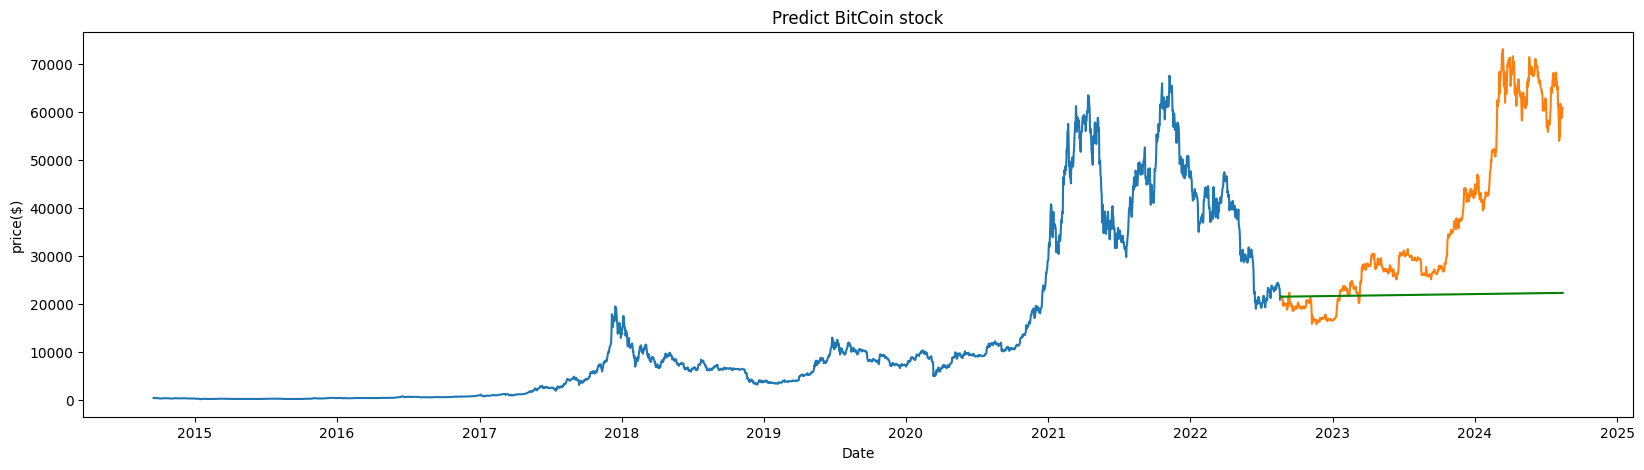

In [8]:
# 최적모델 예측 시각화

# 인덱스 데이터타입 변경
train.index = pd.to_datetime(train.index)
test.index =  pd.to_datetime(test.index)

# 그래프 그리기
plt.figure(figsize=(20, 5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, best_model.forecast(len(test)), label='Forecast', color='g')

# 그래프 제목 및 레이블 설정
plt.title('Predict BitCoin stock')
plt.xlabel('Date')
plt.ylabel('price($)')

plt.show()

In [ ]:
# 로그 변환 (데이터에 1을 더하여 양수로 만듦)
log_train = np.log1p(train)
log_test = np.log1p(test)

# 모델 학습 및 생성
model = ExponentialSmoothing(
    log_train,
    trend=best_params['trend'],
    seasonal=best_params['seasonal'],
    seasonal_periods=best_params['seasonal_periods'],
    damped_trend=best_params['damped_trend'],
).fit()

# 예측
predictions = model.forecast(len(log_test))

# 평가지표
mse = mean_squared_error(log_test, predictions)
mae = mean_absolute_error(log_test, predictions)
mape = mean_absolute_percentage_error(log_test, predictions)
r2 = r2_score(log_test, predictions)

print("MSE", mse)
print("MSE", mae)
print("MAPE", mape)
print("R2", r2)

In [ ]:
# 축소 학습 예측

# 기간 축소
sort_df = df.loc['2024-04-01' : '2024-06-30']

# 훈련, 테스트 데이터로 나누기
train_size = int(len(sort_df) * 0.7)
train = sort_df['sc_coin'][:train_size]
test = sort_df['sc_coin'][train_size:]

# 파라미터 조합 설정
param_grid = {
    'trend': [None, 'add', 'mul'],
    'seasonal': [None, 'add', 'mul'],
    'seasonal_periods': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    'damped_trend': [True, False],
}

# 하이퍼파라미터 초기화
best_score = float('inf')
best_params = None
best_model = None

# 그리드 서치 수행
for params in ParameterGrid(param_grid):  # ParameterGrid를 통한 파라미터 조합 생성
    try:
        # 모델 생성 및 학습
        model = ExponentialSmoothing(
            train,
            trend=params['trend'],
            seasonal=params['seasonal'],
            seasonal_periods=params['seasonal_periods'],
            damped_trend=params['damped_trend']
        ).fit()

        # 예측
        predictions = model.forecast(len(test))
        
        # 평가지표
        mse = mean_squared_error(test, predictions)
        mae = mean_absolute_error(test, predictions)
        mape = mean_absolute_percentage_error(test, predictions)
        r2 = r2_score(test, predictions)
        
        # MSE 기준 최적모델 저장
        if mse < best_score:
            best_score = mse
            best_params = params
            best_model = model
            best_metrics = {
                'MSE': mse,
                'MAE': mae,
                'MAPE': mape,
                'R²': r2
            }

    except Exception as e:
        print(f"Error with parameters {params}: {e}")

In [40]:
# 결과 출력
print("Best Parameters:", best_params)
print("Best MSE:", best_score)
print("Best Metrics:", best_metrics)

Best Parameters: {'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 8, 'trend': 'add'}
Best MSE: 4625475.088910258
Best Metrics: {'MSE': 4625475.088910258, 'MAE': 1832.398339287182, 'MAPE': 0.028142275577040406, 'R²': 0.5892897815314446}


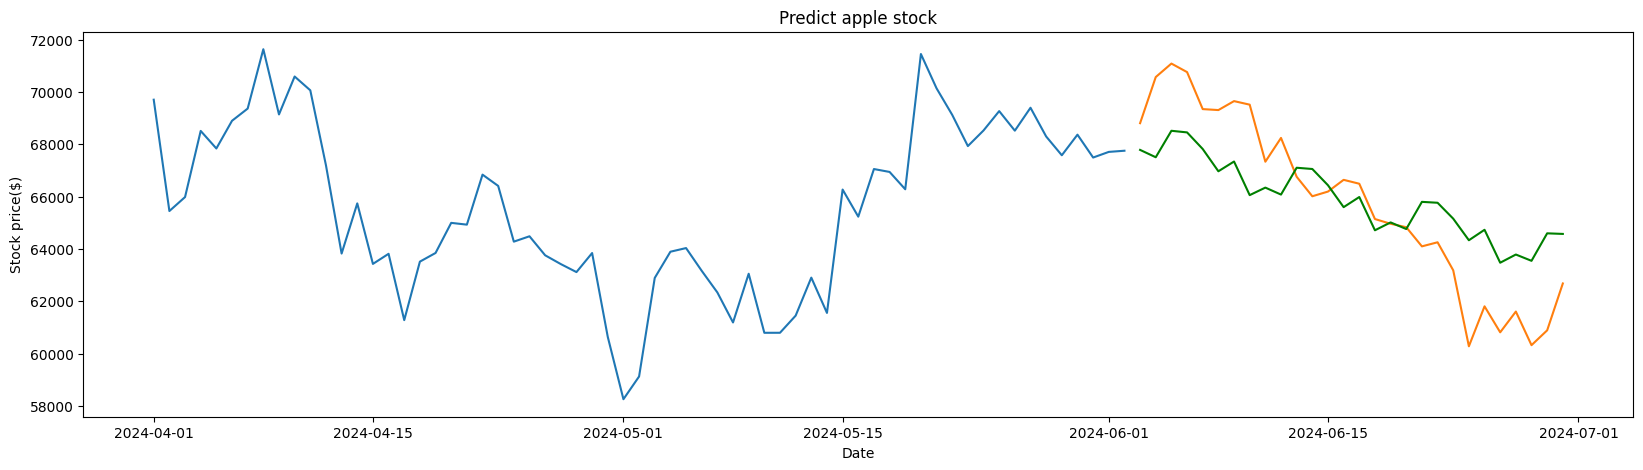

In [41]:
# 최적모델 예측 시각화

# 인덱스 데이터타입을 date로 변경
train.index = pd.to_datetime(train.index)
test.index =  pd.to_datetime(test.index)

# 그래프 그리기
plt.figure(figsize=(20, 5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, best_model.forecast(len(test)), label='Forecast', color='g')

# 그래프 제목 및 레이블 설정
plt.title('Predict apple stock')
plt.xlabel('Date')
plt.ylabel('Stock price($)')

plt.show()

In [ ]:
# 학습, 테스트 크기 설정
window_size = 21  # 3주 학습
test_size = 7    # 1주 테스트

# 예측 결과 저장 데이터프레임 초기화
results_df = pd.DataFrame(columns=['Date', 'Actual', 'Predicted'])

for start in range(0, len(df) - window_size - test_size + 1, test_size):
    train_data = df['sc_coin'][start:start + window_size]
    test_data = df['sc_coin'][start + window_size:start + window_size + test_size]

    # 모델 생성 및 학습
    model = ExponentialSmoothing(
        train_data,
        trend=best_params['trend'],
        seasonal=best_params['seasonal'],
        seasonal_periods=best_params['seasonal_periods'],
        damped_trend=best_params['damped_trend'],
    ).fit()

    # 예측
    prediction = model.forecast(len(test_data))

    # 평가지표
    mse = mean_squared_error(test_data, prediction)
    mae = mean_absolute_error(test_data, prediction)
    mape = mean_absolute_percentage_error(test_data, prediction)
    r2 = r2_score(test_data, prediction)
    

    # 결과를 데이터프레임에 저장
    temp_df = pd.DataFrame({
        'Date': test_data.index,
        'Actual': test_data.values,
        'Predicted': prediction,
        'MSE': mse,
        'MAE': mae,
        'MAPE': mape,
        'R²': r2
    })

    results_df = pd.concat([results_df, temp_df])

In [22]:
results_df

,Date,Actual,Predicted,MSE,MAE,MAPE,R²
2014-10-08,2014-10-08,352.940002,325.834749,4.645954e+03,62.484908,0.164719,-16.849045
2014-10-09,2014-10-09,365.026001,323.017196,4.645954e+03,62.484908,0.164719,-16.849045
2014-10-10,2014-10-10,361.562012,318.465460,4.645954e+03,62.484908,0.164719,-16.849045
2014-10-11,2014-10-11,362.299011,311.958019,4.645954e+03,62.484908,0.164719,-16.849045
2014-10-12,2014-10-12,378.549011,301.920977,4.645954e+03,62.484908,0.164719,-16.849045
...,...,...,...,...,...,...,...
2024-08-09,2024-08-09,60880.113281,54216.688401,4.887680e+07,6508.562999,0.107928,-10.157207
2024-08-10,2024-08-10,60945.812500,52951.740807,4.887680e+07,6508.562999,0.107928,-10.157207
2024-08-11,2024-08-11,58719.484375,52819.366020,4.887680e+07,6508.562999,0.107928,-10.157207
2024-08-12,2024-08-12,59354.515625,51621.783808,4.887680e+07,6508.562999,0.107928,-10.157207


In [23]:
# 결과 출력
print('MSE:', np.mean(results_df['MSE']))
print('MAE:', np.mean(results_df['MAE']))
print('MAPE:', np.mean(results_df['MAPE']))
print('R2:', np.mean(results_df['R²']))

MSE: 5431906.384780515
MAE: 1173.690733881088
MAPE: 0.07122514226800183
R2: -19.48994861129681


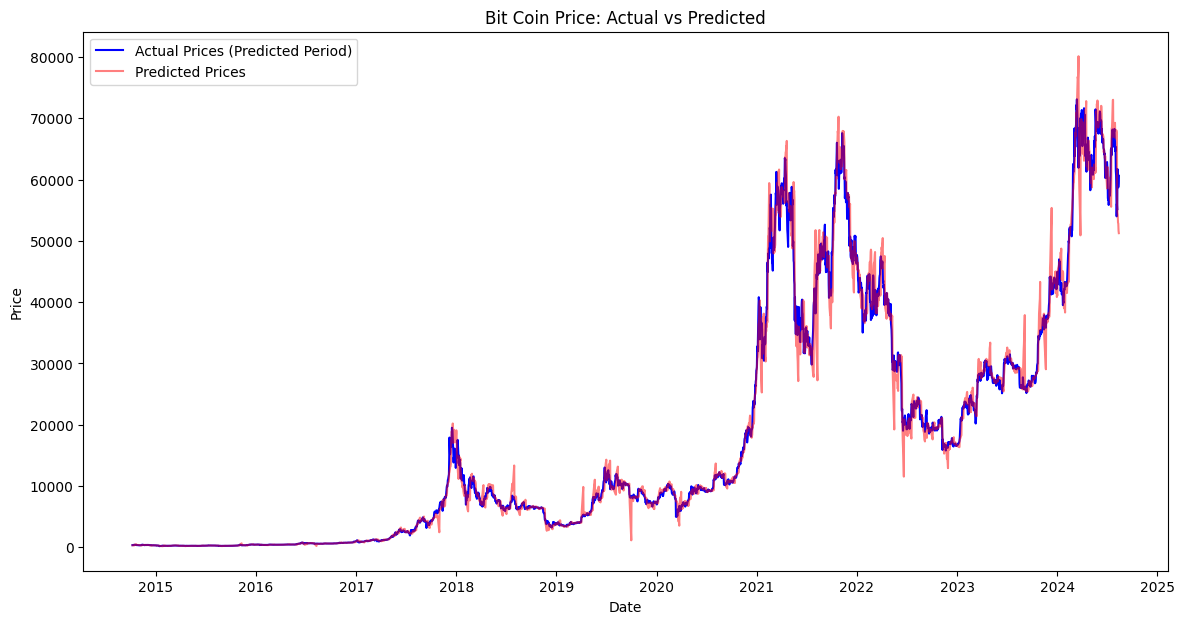

In [24]:
# 단기 예측 시각화

# 인덱스 데이터타입 변경
train_data.index = pd.to_datetime(train_data.index)
test_data.index =  pd.to_datetime(test_data.index)

plt.figure(figsize=(14, 7))

# 실제 전체 주가
# plt.plot(df.index, df['samsung_Close'], label='Actual Prices (Full)', color='blue', linestyle='--')

# 예측 주가 부분만 비교하는 그래프
plt.plot(results_df.index, results_df['Actual'], label='Actual Prices (Predicted Period)', color='blue')
plt.plot(results_df.index, results_df['Predicted'], label='Predicted Prices', color='red', alpha=0.5)

plt.title('Bit Coin Price: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Price($)')
plt.legend()

plt.show()

In [ ]:
# 모델 저장
with open('pastGraphRegression_apple_exponentialSmoothing.pkl', 'wb') as file:
    pickle.dump(model, file)